In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import json
import re

In [13]:
# loading the data
file_path = 'dataset.json'
with open(file_path, 'r') as file:
    data = json.load(file)

In [14]:
df = pd.read_json("dataset.json")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   externalStatus  1222 non-null   object
 1   internalStatus  1222 non-null   object
dtypes: object(2)
memory usage: 19.2+ KB


In [17]:
df.describe()

,externalStatus,internalStatus
count,1222,1222
unique,108,15
top,Gate out,Loaded on Vessel
freq,144,331


In [4]:
df.columns

Index(['externalStatus', 'internalStatus'], dtype='object')

In [5]:
df.isnull().sum()

externalStatus    0
internalStatus    0
dtype: int64

In [6]:
df

,externalStatus,internalStatus
0,PORT OUT,Port Out
1,TERMINAL IN,Inbound Terminal
2,PORT IN,Port In
3,Vessel departure from first POL (Vessel name :...,Departure
4,Vessel arrival at final POD (Vessel name : TIA...,Arrival
...,...,...
1217,Import Loaded on Rail,Loaded on Vessel
1218,Full Transshipment Loaded,Loaded on Vessel
1219,Full Transshipment Loaded,Loaded on Vessel
1220,Export Loaded on Vessel,Loaded on Vessel


## Preprocess text
Preprocess values of text column

- Remove unwanted characters
- Convert text to lowercase
- Remove unwanted spaces
- Remove stopwords

In [7]:
df.text = df.externalStatus.apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))
df.text = df.externalStatus.apply(lambda x: x.lower())
df.text = df.externalStatus.apply(lambda x: x.strip())
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
df.text = df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))

C:\Users\windows\AppData\Local\Temp\ipykernel_6264\199956484.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.text = df.externalStatus.apply(lambda x: re.sub('[^A-Za-z]+', ' ', x))
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\windows\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<AxesSubplot: >

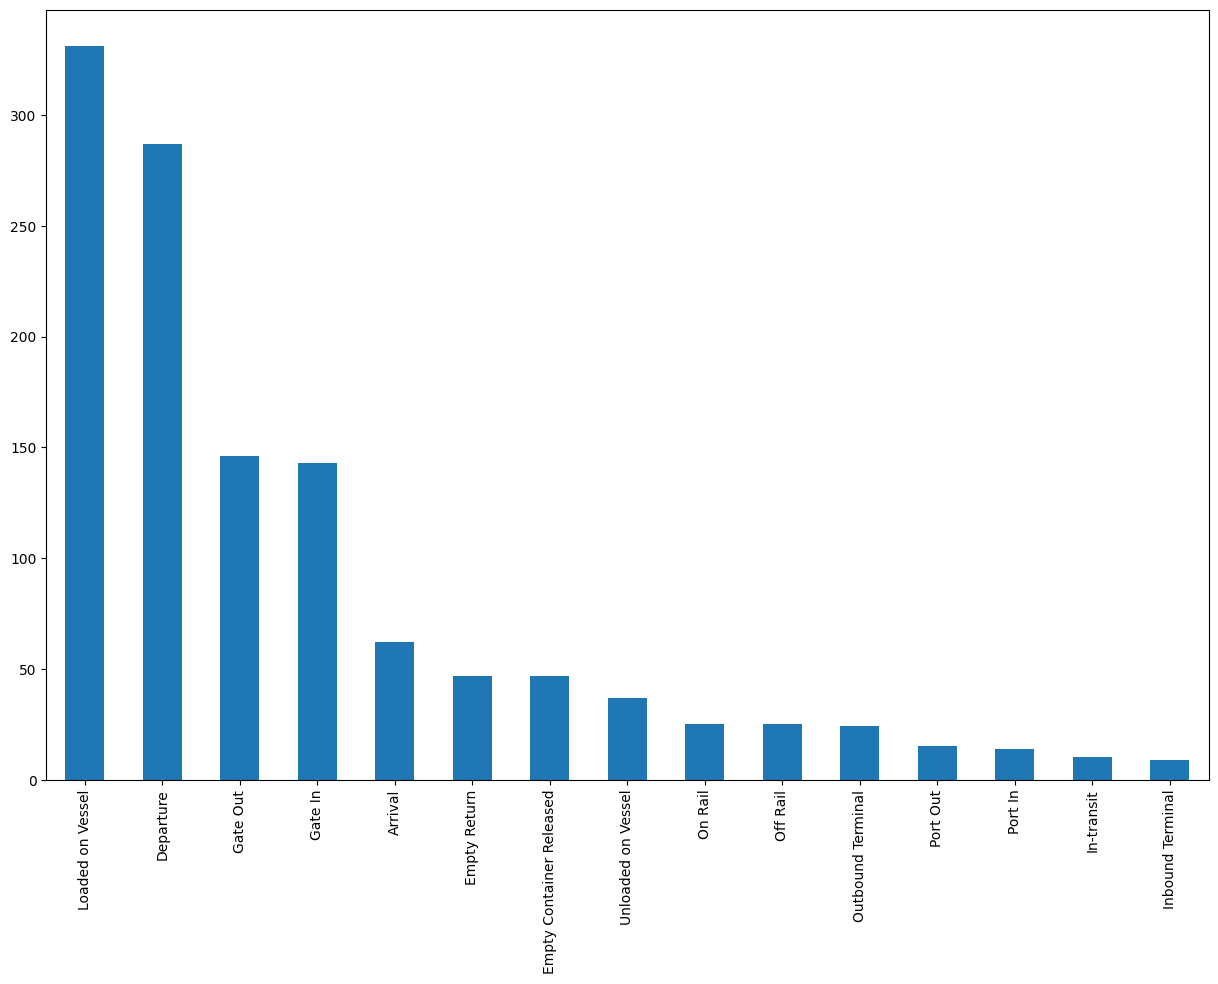

In [10]:
df['internalStatus'].value_counts().plot( kind='bar', figsize=(15,10))

In [18]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'internalStatus' column
df['internalStatus_encoded'] = label_encoder.fit_transform(df['internalStatus'])

# Print the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:")
print(label_mapping)


Label mapping:
{'Arrival': 0, 'Departure': 1, 'Empty Container Released': 2, 'Empty Return': 3, 'Gate In': 4, 'Gate Out': 5, 'In-transit': 6, 'Inbound Terminal': 7, 'Loaded on Vessel': 8, 'Off Rail': 9, 'On Rail': 10, 'Outbound Terminal': 11, 'Port In': 12, 'Port Out': 13, 'Unloaded on Vessel': 14}


In [19]:
texts = df['externalStatus'].tolist()  # Assuming 'text' is the column containing text data
labels = df['internalStatus_encoded'].tolist()  # Assuming 'label' is the column containing labels


# Model Building

In [20]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [21]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


In [22]:
X_train_sparse_tensor = tf.sparse.SparseTensor(
    indices=np.array(X_train_vectorized.nonzero()).T,
    values=X_train_vectorized.data,
    dense_shape=X_train_vectorized.shape
)
X_test_sparse_tensor = tf.sparse.SparseTensor(
    indices=np.array(X_test_vectorized.nonzero()).T,
    values=X_test_vectorized.data,
    dense_shape=X_test_vectorized.shape
)

In [23]:
X_train_reordered = tf.sparse.reorder(X_train_sparse_tensor)
X_test_reordered = tf.sparse.reorder(X_test_sparse_tensor)

In [24]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_vectorized.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(set(labels)), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

C:\Users\windows\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
# Train the model with validation data
history = model.fit(X_train_reordered, np.array(y_train),
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test_reordered, np.array(y_test)))  # Using validation_data instead of validation_split

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.1942 - loss: 2.5592 - val_accuracy: 0.4286 - val_loss: 2.1060
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4710 - loss: 1.9372 - val_accuracy: 0.6898 - val_loss: 1.4901
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6175 - loss: 1.3964 - val_accuracy: 0.6898 - val_loss: 1.0687
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7491 - loss: 0.9840 - val_accuracy: 0.7796 - val_loss: 0.8172
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7879 - loss: 0.8055 - val_accuracy: 0.8327 - val_loss: 0.6460
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8366 - loss: 0.6316 - val_accuracy: 0.8612 - val_loss: 0.5213
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8614 - loss: 0.5082 - val_accuracy: 0.8776 - val_loss: 0.4218
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8842 - loss: 0.4577 - val_accuracy: 0.9265 - val_loss

In [28]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test_reordered, np.array(y_test))
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9281 - loss: 0.2853 
Test Loss: 0.2496911883354187, Test Accuracy: 0.9346938729286194


In [29]:
model.save('model.h5')

## Create training and testing data

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.externalStatus.values, df.internalStatus.values, test_size=0.20, random_state=42)

## Vectorize the data

### Create Bag of Words
- Use CountVectorizer
- Transform the training and testing data

In [72]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

#### Have a look at some feature names

#### View term-document matrix

In [74]:
X_train_bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Create a dictionary to get label counts

In [75]:
label_counts = dict()

for labels in df.internalStatus.values:
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

#### Print the dictionary

In [76]:
label_counts

{'P': 29,
 'o': 845,
 'r': 864,
 't': 998,
 ' ': 1278,
 'O': 235,
 'u': 552,
 'I': 176,
 'n': 823,
 'b': 33,
 'd': 816,
 'T': 33,
 'e': 2235,
 'm': 127,
 'i': 202,
 'a': 1193,
 'l': 597,
 'D': 287,
 'p': 381,
 'A': 62,
 'v': 62,
 'G': 289,
 'L': 331,
 'V': 368,
 's': 793,
 'R': 144,
 'f': 50,
 'E': 94,
 'y': 94,
 '-': 10,
 'C': 47,
 'U': 37}

In [38]:
df['internalStatus'].value_counts()

Loaded on Vessel            331
Departure                   287
Gate Out                    146
Gate In                     143
Arrival                      62
Empty Return                 47
Empty Container Released     47
Unloaded on Vessel           37
On Rail                      25
Off Rail                     25
Outbound Terminal            24
Port Out                     15
Port In                      14
In-transit                   10
Inbound Terminal              9
Name: internalStatus, dtype: int64

## Multi label binarizer

Load a multilabel binarizer and fit it on the labels.

In [77]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=sorted(label_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

## Classifier

Use a linear classifier of your choice, wrap it up in OneVsRestClassifier to train it on every label.

In [78]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf = OneVsRestClassifier(clf)

### Fit the classifier

In [79]:
clf.fit(X_train_bow, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

## Make predictions
- Get predicted labels and scores

In [80]:
predicted_labels = clf.predict(X_test_bow)
predicted_scores = clf.decision_function(X_test_bow)

### Get inverse transform for predicted labels and test labels

In [81]:
pred_inversed = mlb.inverse_transform(predicted_labels)
y_test_inversed = mlb.inverse_transform(y_test)

In [83]:
predicted_labels

array([[1, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

### Print some samples

In [84]:
for i in range(5):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test[i],
        ','.join(y_test_inversed[i]),
        ','.join(pred_inversed[i])
    ))

Title:	Gate out, Empty
True labels:	 ,E,R,e,m,n,p,r,t,u,y
Predicted labels:	 ,E,R,e,m,n,p,r,t,u,y


Title:	Discharge (Vessel name : ELBWATER)
True labels:	D,a,e,p,r,t,u
Predicted labels:	D,a,e,p,r,t,u


Title:	PORT OUT
True labels:	 ,O,P,o,r,t,u
Predicted labels:	 ,O,P,o,r,t,u


Title:	Gate out, Empty
True labels:	 ,E,R,e,m,n,p,r,t,u,y
Predicted labels:	 ,E,R,e,m,n,p,r,t,u,y


Title:	Gate in
True labels:	 ,G,I,a,e,n,t
Predicted labels:	 ,G,I,a,e,n,t




## Calculate accuracy
- Accuracy
- F1-score
- Precision
- Recall

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

def print_evaluation_scores(y_val, predicted):
    print('Accuracy score: ', accuracy_score(y_val, predicted))
    print('F1 score: ', f1_score(y_val, predicted, average='micro'))
    print('Average precision score: ', average_precision_score(y_val, predicted, average='micro'))
    print('Average recall score: ', recall_score(y_val, predicted, average='micro'))

In [61]:
print('Bag-of-words')
print_evaluation_scores(y_test, predicted_labels)

Bag-of-words
Accuracy score:  0.9959183673469387
F1 score:  0.9959183673469387


ValueError: Expected 2D array, got 1D array instead:
array=[ 3  1 13  3  4  0  4 14 11  0 12  8  1  1  2  8  1  0  8  1  8  8  9  8
  5  3  5  5  8  5  1  4  9  1  0  3  9  8  0  8 13  4  1  8 13  8  9 12
  1 10  9  4  8  5  1  1  3  2  8  4  1  2  6 14  5  1  8  8  0  1  1  1
  0  1  4  5  4  2  5  0  8  5  2  2  8  5  4  1  1  4  1  1  7  1  3  7
  0  8  1  2  8  6  1  8  5 13  3  3  8  4  2  4  8 10  1 13  8  4  4  5
  5  4  4  1  1  1  8  3  4  8  3  5  5  8  8  4  2  4  1  8  1  0  8  8
  1 11  1  1  9 12  3  5  8  4 14  1  8 13  0  1  3  8  1  8  8  5  1  1
  5  5  4  1  1  5  0  9  1  5  8  1  1  8  1  8  1  4  8  1  2 12  4  1
 11  4  8  8  2 13  8 14  8 10  1 13  4  8  8  1 11  1  1  8  3  5  8  8
  7  0  4  8  8  5  1  1  1 10  1  1  4  5  8  5  2  1  5  1  5  5  5  2
  8  1  1  8 14].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [31]:
# create a pickle file using serialization
import pickle
pickle_out=open('classifier.pkl','wb')
pickle.dump(clf,pickle_out)
pickle_out.close()